In [30]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()

# Warnings configuration + Script reload
# ==============================================================================
import warnings
import importlib
warnings.filterwarnings('once')

In [2]:
# Data download
# ==============================================================================
df = pd.read_csv(filepath_or_buffer='data/vic_elec.csv', index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True, format='%Y-%m-%d %H:%M:%S')
df.head()

Demand  Temperature     Date  Holiday
Time                                                                 
2011-12-31 13:00:00+00:00  4382.825174        21.40  15340.0     True
2011-12-31 13:30:00+00:00  4263.365526        21.05  15340.0     True
2011-12-31 14:00:00+00:00  4048.966046        20.70  15340.0     True
2011-12-31 14:30:00+00:00  3877.563330        20.55  15340.0     True
2011-12-31 15:00:00+00:00  4036.229746        20.40  15340.0     True

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2011-12-31 13:00:00+00:00 to 2014-12-31 12:30:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52608 non-null  float64
 1   Temperature  52608 non-null  float64
 2   Date         52608 non-null  float64
 3   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(3)
memory usage: 1.7 MB


In [4]:
df = df.asfreq('30min')
df.index

DatetimeIndex(['2011-12-31 13:00:00+00:00', '2011-12-31 13:30:00+00:00',
               '2011-12-31 14:00:00+00:00', '2011-12-31 14:30:00+00:00',
               '2011-12-31 15:00:00+00:00', '2011-12-31 15:30:00+00:00',
               '2011-12-31 16:00:00+00:00', '2011-12-31 16:30:00+00:00',
               '2011-12-31 17:00:00+00:00', '2011-12-31 17:30:00+00:00',
               ...
               '2014-12-31 08:00:00+00:00', '2014-12-31 08:30:00+00:00',
               '2014-12-31 09:00:00+00:00', '2014-12-31 09:30:00+00:00',
               '2014-12-31 10:00:00+00:00', '2014-12-31 10:30:00+00:00',
               '2014-12-31 11:00:00+00:00', '2014-12-31 11:30:00+00:00',
               '2014-12-31 12:00:00+00:00', '2014-12-31 12:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=52608, freq='30min')

In [5]:
df.head(2)

Demand  Temperature     Date  Holiday
Time                                                                 
2011-12-31 13:00:00+00:00  4382.825174        21.40  15340.0     True
2011-12-31 13:30:00+00:00  4263.365526        21.05  15340.0     True

In [6]:
# Verify that a temporary index is complete
# ==============================================================================
(df.index == pd.date_range(start=df.index.min(),
                             end=df.index.max(),
                             freq=df.index.freq)).all()

print(f"Number of rows with missing values: {df.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [7]:
df.drop(columns=['Date'], inplace=True)
df.resample(rule='h', closed='left', label='right').mean()
df.head()

Demand  Temperature  Holiday
Time                                                        
2011-12-31 13:00:00+00:00  4382.825174        21.40     True
2011-12-31 13:30:00+00:00  4263.365526        21.05     True
2011-12-31 14:00:00+00:00  4048.966046        20.70     True
2011-12-31 14:30:00+00:00  3877.563330        20.55     True
2011-12-31 15:00:00+00:00  4036.229746        20.40     True

In [8]:
# Split data into train-val-test
# ==============================================================================
from utils import split_data

end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data, data_train, data_val, data_test = split_data(df, end_train, end_validation)

Train dates      : 2012-01-01 00:00:00+00:00 --- 2013-12-31 23:30:00+00:00  (n=35088)
Validation dates : 2014-01-01 00:00:00+00:00 --- 2014-11-30 23:30:00+00:00  (n=16032)
Test dates       : 2014-12-01 00:00:00+00:00 --- 2014-12-30 23:00:00+00:00  (n=1439)


In [9]:
# Interactive plot of time series
# ==============================================================================
from utils import plot_interactive_time_series

plot_interactive_time_series(data_train, data_val, data_test)

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



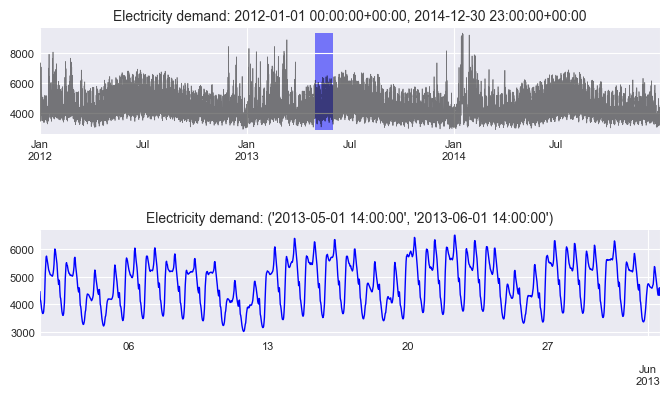

In [10]:
from utils import plot_zoomed_time_series

zoom_range = ('2013-05-01 14:00:00', '2013-06-01 14:00:00')
plot_zoomed_time_series(data, zoom_range)

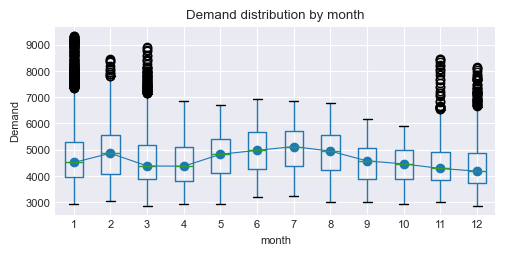

In [11]:
# Demand distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=ax,)
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('')
plt.show()

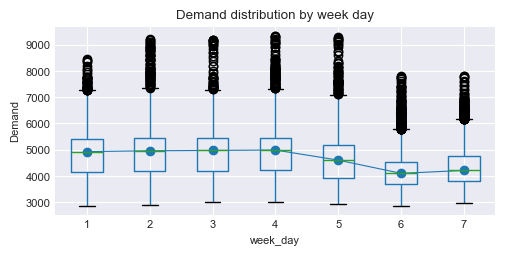

In [12]:
# Demand distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=ax)
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('')
plt.show()

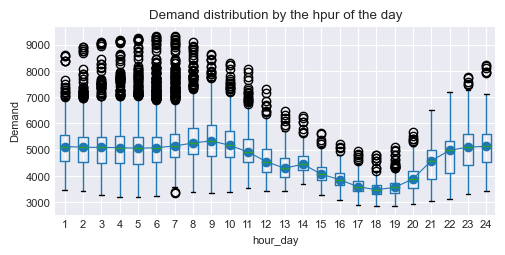

In [13]:
# Demand distribution by the hour of the day
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=ax)
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the hpur of the day')
fig.suptitle('')
plt.show()

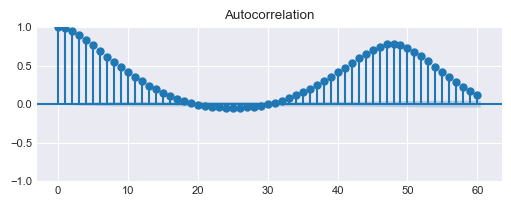

In [14]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2))
plot_acf(data.Demand, ax=ax, lags=60)
plt.show()

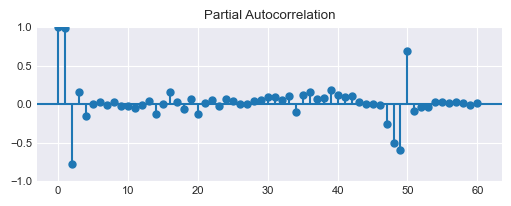

In [15]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2))
plot_pacf(data.Demand, ax=ax, lags=60)
plt.show()

In [16]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data_test['Demand'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 48 
Training range: [Timestamp('2014-12-01 00:00:00+0000', tz='UTC'), Timestamp('2014-12-30 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Creation date: 2024-07-24 12:09:38 
Last fit date: 2024-07-24 12:09:38 
Skforecast version: 0.12.1 
Python version: 3.12.2 
Forecaster id: None 

In [17]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error (MAE): 306.86680479777624


In [18]:
from utils import plot_predictions_vs_real

plot_predictions_vs_real(data_test, predictions)

In [19]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00+0000', tz='UTC'), Timestamp('2014-11-30 23:30:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_fr

In [20]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 51120
Number of observations used for backtesting: 1439
    Number of folds: 60
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:30:00+00:00  (n=51120)
    Validation: 2014-12-01 00:00:00+00:00 -- 2014-12-01 11:30:00+00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:30:00+00:00  (n=51120)
    Validation: 2014-12-01 12:00:00+00:00 -- 2014-12-01 23:30:00+00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:30:00+00:00  (n=51120)
    Validation: 2014-12-02 00:00:00+00:00 -- 2014-12-02 11:30:00+00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:30:00+00:00  (n=51120)
    Validation: 2014-12-02 12:00:00+00:00

  0%|          | 0/60 [00:00<?, ?it/s]

In [21]:
plot_predictions_vs_real(data_test, predictions)

In [22]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24, # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:end_validation, 'Demand'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.050765544282894995, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
  Backtesting metric: 214.1864555604521



In [23]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.050765544282894995, max_depth=9,
              n_estimators=1000, random_state=123, reg_alpha=0.8,
              reg_lambda=0.2, verbose=-1) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: None 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00+0000', tz='UTC'), Timestamp('2014-11-30 23:30:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.050765544282894995, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'r

In [24]:
results_search.head(10)

lags  \
9   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
12  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
16  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
15  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
0   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
13  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
10  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
2   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
18  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
19  [1, 2, 3, 23, 24, 25, 47, 48, 49]   

                                               params  mean_absolute_error  \
9   {'n_estimators': 1000, 'max_depth': 9, 'learni...           214.186456   
12  {'n_estimators': 1000, 'max_depth': 10, 'learn...           217.694259   
16  {'n_estimators': 600, 'max_depth': 9, 'learnin...           217.787092   
15  {'n_estimators': 900, 'max_depth': 9, 'learnin...           217.818795   
0   {'n_estimators': 1000, 'max_depth': 5, 'learni...           218.081531   
13  {'n_estimators': 1200, 'max_depth': 10, 'learn...           221.382125   
10  {'n_estimators': 600, 'max_depth': 10, 'learni...           221.439860   
2   {'n_estimators': 800, 'max_depth': 8, 'learnin...           222.226292   
18  {'n_estimators': 1100, 'max_depth': 9, 'learni...           227.762844   
19  {'n_estimators': 1000, 'max_depth': 7, 'learni...           231.972930   

    n_estimators  max_depth  learning_rate  reg_alpha  reg_lambda  
9         1000.0        9.0       0.050766        0.8         0.2  
12        1000.0       10.0       0.116468        0.7         0.2  
16         600.0        9.0       0.174986        0.0         0.0  
15         900.0        9.0       0.066604        0.7         0.2  
0         1000.0        5.0       0.121157        0.6         0.7  
13        1200.0       10.0       0.142416        0.8         0.1  
10         600.0       10.0       0.205234        0.9         0.0  
2          800.0        8.0       0.099421        0.1         0.5  
18        1100.0        9.0       0.012037        0.5         0.2  
19        1000.0        7.0       0.230295        0.9         0.1

In [25]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error: 227.98


pred
2014-12-01 00:00:00+00:00  5564.653498
2014-12-01 00:30:00+00:00  5561.757554
2014-12-01 01:00:00+00:00  5544.200386
2014-12-01 01:30:00+00:00  5592.869110
2014-12-01 02:00:00+00:00  5662.965528

In [26]:
plot_predictions_vs_real(data_test, predictions)

In [53]:
import utils
importlib.reload(utils)

<module 'utils' from '/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/utils.py'>

In [36]:


name = "Melbourne"
region = "Australia"
timezone = 'Australia/Melbourne'
latitude = -37.8
longitude = 144.95
exogenous_features = utils.add_exogenous_features(data=data, name=name, region=region, timezone=timezone, latitude=latitude, longitude=longitude)


In [37]:
exogenous_features

month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 00:30:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   
2012-01-01 01:30:00+00:00      1            52         7         2   
2012-01-01 02:00:00+00:00      1            52         7         3   
...                          ...           ...       ...       ...   
2014-12-30 21:00:00+00:00     12             1         2        22   
2014-12-30 21:30:00+00:00     12             1         2        22   
2014-12-30 22:00:00+00:00     12             1         2        23   
2014-12-30 22:30:00+00:00     12             1         2        23   
2014-12-30 23:00:00+00:00     12             1         2        24   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 00:30:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   
2012-01-01 01:30:00+00:00             6           20              14   
2012-01-01 02:00:00+00:00             6           20              14   
...                                 ...          ...             ...   
2014-12-30 21:00:00+00:00             6           20              14   
2014-12-30 21:30:00+00:00             6           20              14   
2014-12-30 22:00:00+00:00             6           20              14   
2014-12-30 22:30:00+00:00             6           20              14   
2014-12-30 23:00:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0         29.1             29.100000   
2012-01-01 00:30:00+00:00            0         30.2             29.650000   
2012-01-01 01:00:00+00:00            0         31.3             30.200000   
2012-01-01 01:30:00+00:00            0         32.0             30.650000   
2012-01-01 02:00:00+00:00            0         32.7             31.060000   
...                                ...          ...                   ...   
2014-12-30 21:00:00+00:00            0         13.4             14.625000   
2014-12-30 21:30:00+00:00            0         14.7             14.529167   
2014-12-30 22:00:00+00:00            0         16.4             14.508333   
2014-12-30 22:30:00+00:00            0         16.8             14.508333   
2014-12-30 23:00:00+00:00            0         17.7             14.537500   

                           temp_roll_mean_7_day  temp_roll_max_1_day  \
Time                                                                   
2012-01-01 00:00:00+00:00             29.100000                 29.1   
2012-01-01 00:30:00+00:00             29.650000                 30.2   
2012-01-01 01:00:00+00:00             30.200000                 31.3   
2012-01-01 01:30:00+00:00             30.650000                 32.0   
2012-01-01 02:00:00+00:00             31.060000                 32.7   
...                                         ...                  ...   
2014-12-30 21:00:00+00:00             19.366667                 17.0   
2014-12-30 21:30:00+00:00             19.333929                 17.0   
2014-12-30 22:00:00+00:00             19.316071                 17.0   
2014-12-30 22:30:00+00:00             19.303571                 17.0   
2014-12-30 23:00:00+00:00             19.300595                 17.7   

                           temp_roll_min_1_day  temp_roll_max_7_day  \
Time                                                                  
2012-01-01 00:00:00+00:00                 29.1                 29.1   
2012-01-01 00:30:00+00:00  

In [39]:
month_encoded = utils.cyclical_encoding(exogenous_features['month'], cycle_length=12)
week_of_year_encoded = utils.cyclical_encoding(exogenous_features['week_of_year'], cycle_length=52)
week_day_encoded = utils.cyclical_encoding(exogenous_features['week_day'], cycle_length=7)
hour_day_encoded = utils.cyclical_encoding(exogenous_features['hour_day'], cycle_length=24)
sunrise_hour_encoded = utils.cyclical_encoding(exogenous_features['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = utils.cyclical_encoding(exogenous_features['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

exogenous_features = pd.concat([exogenous_features, cyclical_features], axis=1)
exogenous_features.head(3)

month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 00:30:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 00:30:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0         29.1                 29.10   
2012-01-01 00:30:00+00:00            0         30.2                 29.65   
2012-01-01 01:00:00+00:00            0         31.3                 30.20   

                           ...  week_of_year_sin  week_of_year_cos  \
Time                       ...                                       
2012-01-01 00:00:00+00:00  ...               0.0               1.0   
2012-01-01 00:30:00+00:00  ...               0.0               1.0   
2012-01-01 01:00:00+00:00  ...               0.0               1.0   

                           week_day_sin  week_day_cos  hour_day_sin  \
Time                                                                  
2012-01-01 00:00:00+00:00 -2.449294e-16           1.0      0.258819   
2012-01-01 00:30:00+00:00 -2.449294e-16           1.0      0.258819   
2012-01-01 01:00:00+00:00 -2.449294e-16           1.0      0.500000   

                           hour_day_cos  sunrise_hour_sin  sunrise_hour_cos  \
Time                                                                          
2012-01-01 00:00:00+00:00      0.965926               1.0      6.123234e-17   
2012-01-01 00:30:00+00:00      0.965926               1.0      6.123234e-17   
2012-01-01 01:00:00+00:00      0.866025               1.0      6.123234e-17   

                           sunset_hour_sin  sunset_hour_cos  
Time                                                         
2012-01-01 00:00:00+00:00        -0.866025              0.5  
2012-01-01 00:30:00+00:00        -0.866025              0.5  
2012-01-01 01:00:00+00:00        -0.866025              0.5  

[3 rows x 30 columns]

In [40]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'Temperature',
    'Holiday'
]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)


month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 00:30:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   
2012-01-01 01:30:00+00:00      1            52         7         2   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 00:30:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   
2012-01-01 01:30:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0         29.1                 29.10   
2012-01-01 00:30:00+00:00            0         30.2                 29.65   
2012-01-01 01:00:00+00:00            0         31.3                 30.20   
2012-01-01 01:30:00+00:00            0         32.0                 30.65   

                           ...  poly_temp_roll_min_1_day__temp_roll_max_7_day  \
Time                       ...                                                  
2012-01-01 00:00:00+00:00  ...                                         846.81   
2012-01-01 00:30:00+00:00  ...                                         878.82   
2012-01-01 01:00:00+00:00  ...                                         910.83   
2012-01-01 01:30:00+00:00  ...                                         931.20   

                           poly_temp_roll_min_1_day__temp_roll_min_7_day  \
Time                                                                       
2012-01-01 00:00:00+00:00                                         846.81   
2012-01-01 00:30:00+00:00                                         846.81   
2012-01-01 01:00:00+00:00                                         846.81   
2012-01-01 01:30:00+00:00                                         846.81   

                           poly_temp_roll_min_1_day__Temperature  \
Time                                                               
2012-01-01 00:00:00+00:00                                 846.81   
2012-01-01 00:30:00+00:00                                 878.82   
2012-01-01 01:00:00+00:00                                 910.83   
2012-01-01 01:30:00+00:00                                 931.20   

                           poly_temp_roll_min_1_day__Holiday  \
Time                                                           
2012-01-01 00:00:00+00:00                               29.1   
2012-01-01 00:30:00+00:00                               29.1   
2012-01-01 01:00:00+00:00                               29.1   
2012-01-01 01:30:00+00:00                               29.1   

                           poly_temp_roll_max_7_day__temp_roll_min_7_day  \
Time                                                                       
2012-01-01 00:00:00+00:00                                         846.81   
2012-01-01 00:30:00+00:00                                         878.82   
2012-01-01 01:00:00+00:00                                         910.83   
2012-01-01 01:30:00+00:00                                         931.20   

                           poly_temp_roll_max_7_day__Temperature  \
Time                                                               
2012-01-01 00:00:00+00:00                                 846.81   
2012-01-01 00:30:00+00:00                                 912.04   
2012-01-01 01:00:00+00:00                                 979.69   
2012-01-01 01:30:00+00:00                                1024.00   

                           poly_temp_roll_max_7_day__Holiday  \
Time                                      

In [41]:
exogenous_features

month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 00:30:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   
2012-01-01 01:30:00+00:00      1            52         7         2   
2012-01-01 02:00:00+00:00      1            52         7         3   
...                          ...           ...       ...       ...   
2014-12-30 21:00:00+00:00     12             1         2        22   
2014-12-30 21:30:00+00:00     12             1         2        22   
2014-12-30 22:00:00+00:00     12             1         2        23   
2014-12-30 22:30:00+00:00     12             1         2        23   
2014-12-30 23:00:00+00:00     12             1         2        24   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 00:30:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   
2012-01-01 01:30:00+00:00             6           20              14   
2012-01-01 02:00:00+00:00             6           20              14   
...                                 ...          ...             ...   
2014-12-30 21:00:00+00:00             6           20              14   
2014-12-30 21:30:00+00:00             6           20              14   
2014-12-30 22:00:00+00:00             6           20              14   
2014-12-30 22:30:00+00:00             6           20              14   
2014-12-30 23:00:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0         29.1             29.100000   
2012-01-01 00:30:00+00:00            0         30.2             29.650000   
2012-01-01 01:00:00+00:00            0         31.3             30.200000   
2012-01-01 01:30:00+00:00            0         32.0             30.650000   
2012-01-01 02:00:00+00:00            0         32.7             31.060000   
...                                ...          ...                   ...   
2014-12-30 21:00:00+00:00            0         13.4             14.625000   
2014-12-30 21:30:00+00:00            0         14.7             14.529167   
2014-12-30 22:00:00+00:00            0         16.4             14.508333   
2014-12-30 22:30:00+00:00            0         16.8             14.508333   
2014-12-30 23:00:00+00:00            0         17.7             14.537500   

                           ...  poly_temp_roll_min_1_day__temp_roll_max_7_day  \
Time                       ...                                                  
2012-01-01 00:00:00+00:00  ...                                         846.81   
2012-01-01 00:30:00+00:00  ...                                         878.82   
2012-01-01 01:00:00+00:00  ...                                         910.83   
2012-01-01 01:30:00+00:00  ...                                         931.20   
2012-01-01 02:00:00+00:00  ...                                         951.57   
...                        ...                                            ...   
2014-12-30 21:00:00+00:00  ...                                         374.40   
2014-12-30 21:30:00+00:00  ...                                         374.40   
2014-12-30 22:00:00+00:00  ...                                         374.40   
2014-12-30 22:30:00+00:00  ...                                         374.40   
2014-12-30 23:00:00+00:00  ...                                         374.40   

                           poly_temp_roll_min_1_day__temp_roll_min_7_day  \
Time                                           

In [42]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []

# Columns that ends with _sin or _cos are selected
exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())

# Columns that start with temp_ are selected
exog_features.extend(exogenous_features.filter(regex='^temp_.*').columns.tolist())

# Columns that start with holiday_ are selected
exog_features.extend(exogenous_features.filter(regex='^holiday_.*').columns.tolist())

# Include original features
exog_features.extend(['Temperature', 'Holiday'])

In [43]:
# Merge target and exogenous variables in the same DataFrame
# ==============================================================================
data = data[['Demand']].merge(
           exogenous_features[exog_features],
           left_index=True,
           right_index=True,
           how='left'
       )

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. Due to holiday_next_day there are missing values at the end.
data = data.dropna()
data = data.astype('float32')

# Split data into train-val-test
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

In [44]:
# Create forecaster
# ==============================================================================
params = {
    'n_estimators': 800,
    'max_depth': 8,
    'learning_rate': 0.0551314,
    'reg_alpha': 0.4,
    'reg_lambda': 0.4,
    'random_state': 15926,
    'verbose': -1
}
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )

In [45]:
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          exog               = data[exog_features],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error: 119.70


pred
2014-12-01 00:00:00+00:00  5555.477314
2014-12-01 00:30:00+00:00  5539.322215
2014-12-01 01:00:00+00:00  5515.042489
2014-12-01 01:30:00+00:00  5499.125362
2014-12-01 02:00:00+00:00  5500.430385

In [46]:
plot_predictions_vs_real(data_test, predictions)

In [47]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
forecaster.fit(
    y    = data.loc[:end_train, 'Demand'],
    exog = data.loc[:end_train, exog_features]
)

In [48]:
# Predict intervals
# ==============================================================================
# Since the model has been trained with exogenous variables, they must be provided
# for the prediction.
predictions = forecaster.predict_interval(
                  exog     = data.loc[end_train:, exog_features],
                  steps    = 24,
                  interval = [10, 90], 
              )
predictions.head()

pred  lower_bound  upper_bound
2014-01-01 00:00:00+00:00  3733.127384  3702.650598  3764.714946
2014-01-01 00:30:00+00:00  3790.622667  3739.324450  3835.175839
2014-01-01 01:00:00+00:00  3826.675297  3769.277407  3889.173937
2014-01-01 01:30:00+00:00  3871.438576  3793.533238  3948.853019
2014-01-01 02:00:00+00:00  3887.163492  3782.371558  3974.997005

In [49]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'Demand'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 24,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'Demand'] - predictions_val['pred']
residuals = residuals.dropna()

  0%|          | 0/668 [00:00<?, ?it/s]

negative    8657
positive    7375
Name: count, dtype: int64


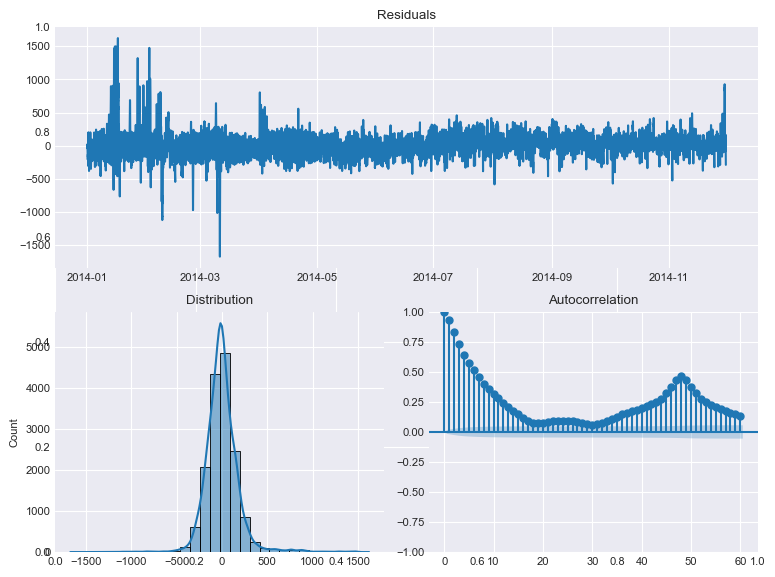

In [50]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
_ = plot_residuals(residuals=residuals, fig=fig)
fig.tight_layout()

In [51]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    residuals = residuals,
    y_pred    = data.loc[predictions_val.index, 'Demand']
)

In [52]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True, # Residuals conditioned on predicted values
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

  0%|          | 0/60 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2014-12-01 00:00:00+00:00  5555.477314  5389.664413  5742.774879
2014-12-01 00:30:00+00:00  5539.322215  5282.827296  5877.867415
2014-12-01 01:00:00+00:00  5515.042489  5147.170884  6082.642202
2014-12-01 01:30:00+00:00  5499.125362  5097.351205  6476.419705
2014-12-01 02:00:00+00:00  5500.430385  5033.588940  6850.092593

In [54]:
utils.plot_prediction_intervals_vs_real(data_test=data_test, predictions=predictions)

In [55]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )
coverage = inside_interval.mean()
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Total area of the interval: 1830957.61
Predicted interval coverage: 71.72 %


In [56]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'Demand'],
    exog = data.loc[:end_validation, exog_features]
)

In [57]:
# Model-specific feature importances
# ==============================================================================
feature_importances = forecaster.get_feature_importances()
feature_importances.sort_values(by='importance', ascending=False).head(10)

feature  importance
0                              lag_1        2445
1                              lag_2        1071
3                              lag_4         904
31                      hour_day_cos         808
2                              lag_3         775
30                      hour_day_sin         738
110                      Temperature         725
23                            lag_24         725
87   poly_hour_day_sin__hour_day_cos         705
14                            lag_15         591

In [58]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Demand'],
                       exog = data_train[exog_features]
                   )

In [59]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=123)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

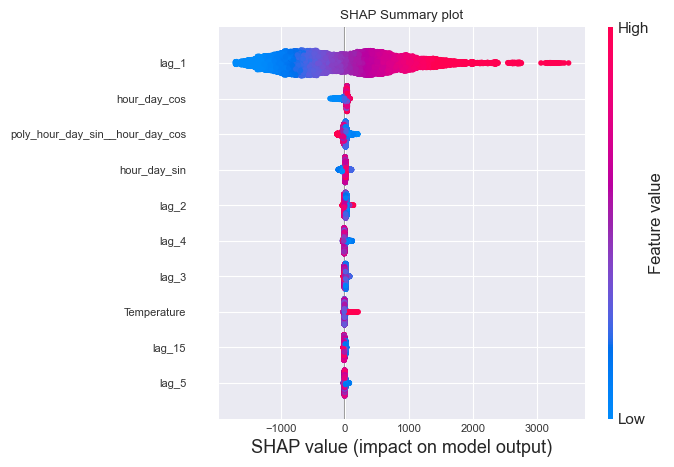

In [60]:
# Shap summary plot (top 10)
# ==============================================================================
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [61]:
# Force plot for the first observation
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])

In [62]:
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth = 5,
                random_state = 15926,
                verbose = -1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags = 24
             )

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data_train['Demand'],
    exog            = data_train[exog_features],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=68308) is multi-threaded, use of fork() may lead to deadlocks in the child.



Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 35064
Total number of records used for feature selection: 17532
Number of features available: 112
    Autoreg (n=24)
    Exog    (n=88)
Number of features selected: 68
    Autoreg (n=24) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    Exog    (n=44) : ['month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunset_hour_cos', 'poly_month_sin__week_of_year_sin', 'poly_month_sin__week_of_year_cos', 'poly_month_sin__week_day_sin', 'poly_month_sin__week_day_cos', 'poly_month_sin__hour_day_sin', 'poly_month_sin__hour_day_cos', 'poly_month_cos__week_of_year_sin', 'poly_month_cos__week_day_sin', 'poly_month_cos__week_day_cos', 'poly_month_cos__hour_day_sin', 'poly_month_cos__hour_day_cos', 'poly_week_of_year_sin__week_of_year_cos', 'poly_week_of_year_sin__week_day_s

In [63]:
# Create a forecaster with the selected features
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = selected_lags,
             )

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_lgbm, predictions = backtesting_forecaster(
                               forecaster         = forecaster,
                               y                  = data['Demand'],
                               exog               = data[selected_exog],
                               steps              = 24,
                               metric             = 'mean_absolute_error',
                               initial_train_size = len(data[:end_validation]),
                               refit              = False,
                               n_jobs             = 'auto',
                               verbose            = False,
                               show_progress      = True
                           )
print(f"Backtest error: {metric_lgbm:.2f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error: 119.01


In [64]:
utils.plot_predictions_vs_real(data_test, predictions)

In [65]:
# Forecaster with direct method
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(**params),
                 steps            = 24, # Steps to forecast
                 lags             = selected_lags
             )

# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          exog               = data[selected_exog],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric:.2f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error (MAE): 107.30


In [66]:
utils.plot_predictions_vs_real(data_test, predictions)